In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import random, getopt, os, sys, json

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler

from sklearn.metrics import f1_score,confusion_matrix

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

from Lamp.AttrDict.AttrDict import *
from Lamp.Model.Dataloader import *
from Lamp.Model.BaseModel import *
from Lamp.Model.Resnet import *

In [3]:
def set_seed(seed):
    """ Set the random seed """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def load_config(cfg_path):
    """  """
    if os.path.splitext(cfg_path)[-1] == '.json':
        return AttrDict.from_json_path(cfg_path)
    elif os.path.splitext(cfg_path)[-1] in ['.yaml', '.yml']:
        return AttrDict.from_yaml_path(cfg_path)
    else:
        raise ValueError(f"Unsupported config file format. Only '.json', '.yaml' and '.yml' files are supported.")

def resnet(layers=[3, 4, 6, 3],channels=3, num_classes=1000):
    model = ResNet(BasicBlock,layers,channels=channels,num_classes=num_classes)
    return model

class Classifier(BaseModelSingle):
    def __init__(self, net: nn.Module, opt: Optimizer = None, sched: _LRScheduler = None, 
        logger: Logger = None, print_progress: bool = True, device: str = 'cuda:0', **kwargs):
        super().__init__(net, opt=opt, sched=sched, logger=logger, print_progress=print_progress, device=device, **kwargs)

    def forward_loss(self, data: Tuple[Tensor]) -> Tensor:
        """  """
        pass

    def predict(self, loader):
        """  """
        labels = []
        self.net.eval()
        with torch.no_grad():
            for b, data in enumerate(loader):
                input, label = data
                input = input.to(self.device)
                label = label.to(self.device).long()

                output = self.net(input)
                pred = torch.argmax(output, dim=1)

                labels += list(zip(pred.cpu().data.tolist(), label.cpu().data.tolist()))

            pred, label = zip(*labels)
            
        return pred, label

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    bottom, top = ax.get_ylim()
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_ylim(bottom, top)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.grid(False)
    return ax

### Test Lab

In [5]:
# Load config file
ifile = "../Models/config/MAR_RESNET34_PADDED_256_ALL_NEW.yaml"

inputs = load_config(ifile)

# Handle config_file inputs
seed = int(inputs.Seed)
layers = inputs.Model.Layers # [3, 4, 6, 3] for ResNet34 and [2, 2, 2, 2] for ResNet18
classes = inputs.Model.OutClasses
channels = inputs.Model.Channels

# Handle file paths
root_path = os.path.abspath(os.path.join(os.getcwd(), '..')) # Workspace path to Cuttings_Characterisation 
path_model = f"{root_path}/{inputs.PathSave}/{inputs.ModelName}"
path_load_data = f"{root_path}/{inputs.LoadPathTestLab}" # Path for the .csv file

# Seed
set_seed(seed)

# Pytorch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

# Read dataset
dataframe = pd.read_csv(path_load_data,index_col=0)

# Transforms (other than MinMaxNorm and ToTensor)
dict_transform = {
        "Padding":Padding,
        "CenterCrop":tf.CenterCrop,
        "Resize":tf.Resize,
        }

transforms_test = Transforms(
        [dict_transform[key]([k for k in item.values()] if len(item.values()) > 1 else [k for k in item.values()][0]) for key, item in inputs.TransformTest.items()] 
        )

model_name = f"model_all.pt"
save_model_path = f"{path_model}/{model_name}"

testDataset = Dataset(
        dataframe.reset_index(drop=True),
        transforms=transforms_test.get_transforms()
        )

test_dataloader = torch.utils.data.DataLoader(
        testDataset, 
        batch_size=4,
        shuffle=False
        )

net = resnet(layers=layers,channels=channels,num_classes=classes)

classifier = Classifier(
        net=net, 
        device=device
        )

classifier.load(save_model_path)

pred, label = classifier.predict(test_dataloader)

cuda:0
NVIDIA GeForce 940MX


[[   0    0    0    0    0]
 [   0    0    0    0    0]
 [  73    0 1434    0  496]
 [   0  464   37 1423    0]
 [   0    0    0    0    0]]


<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

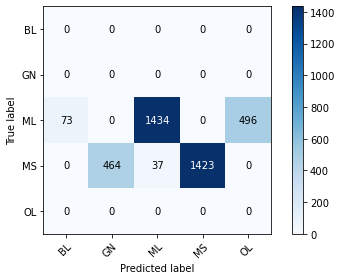

In [6]:
plot_confusion_matrix(label,pred,classes=['BL','GN','ML','MS','OL'])

### Test Borehole

In [7]:
# Load config file
ifile = "../Models/config/MAR_RESNET34_PADDED_256_ALL_NEW.yaml"

inputs = load_config(ifile)

# Handle config_file inputs
seed = int(inputs.Seed)
layers = inputs.Model.Layers # [3, 4, 6, 3] for ResNet34 and [2, 2, 2, 2] for ResNet18
classes = inputs.Model.OutClasses
channels = inputs.Model.Channels

# Handle file paths
root_path = os.path.abspath(os.path.join(os.getcwd(), '..')) # Workspace path to Cuttings_Characterisation 
path_model = f"{root_path}/{inputs.PathSave}/{inputs.ModelName}"
path_load_data = f"{root_path}/{inputs.LoadPathTestBorehole}" # Path for the .csv file

# Seed
set_seed(seed)

# Pytorch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

# Read dataset
dataframe = pd.read_csv(path_load_data,index_col=0)

# Transforms (other than MinMaxNorm and ToTensor)
dict_transform = {
        "Padding":Padding,
        "CenterCrop":tf.CenterCrop,
        "Resize":tf.Resize,
        }

transforms_test = Transforms(
        [dict_transform[key]([k for k in item.values()] if len(item.values()) > 1 else [k for k in item.values()][0]) for key, item in inputs.TransformTest.items()] 
        )

model_name = f"model_all.pt"
save_model_path = f"{path_model}/{model_name}"

testDataset = Dataset(
        dataframe.reset_index(drop=True),
        transforms=transforms_test.get_transforms()
        )

test_dataloader = torch.utils.data.DataLoader(
        testDataset, 
        batch_size=4,
        shuffle=False
        )

net = resnet(layers=layers,channels=channels,num_classes=classes)

classifier = Classifier(
        net=net, 
        device=device
        )

classifier.load(save_model_path)

pred, label = classifier.predict(test_dataloader)

cuda:0
NVIDIA GeForce 940MX


In [ ]:
plot_confusion_matrix(label,pred,classes=['BL','GN','ML','MS','OL'])

### Validation CM

In [2]:
with open('validation.json', 'r') as openfile:
    json_dict = json.load(openfile)

In [3]:
for key, item in json_dict.items():
    print(f"{np.mean(np.array(item))*100:.2f}+/-{np.std(np.array(item))*100:.2f}")

98.10+/-0.53
97.94+/-0.39
98.22+/-0.35


In [4]:
with open('test.json', 'r') as openfile:
    json_dict = json.load(openfile)

In [5]:
json_dict

{'MAR_RESNET34_PADDED_256_ALL': [0.5513114336643749],
 'MAR_RESNET34_CROPPED_256_ALL': [0.06417112299465241],
 'MAR_RESNET34_PADDED_256_ALL_NEW': [0.7275273745861981]}

In [8]:
pd.read_csv('../Dataset/test_mar.csv',index_col=0)

,Paths,Label
0,../Data/Test_New/ML-V1\slice00200 (2021_10_07 ...,2
1,../Data/Test_New/ML-V1\slice00200 (2021_10_07 ...,2
2,../Data/Test_New/ML-V1\slice00200 (2021_10_07 ...,2
3,../Data/Test_New/ML-V1\slice00200 (2021_10_07 ...,2
4,../Data/Test_New/ML-V1\slice00210 (2021_10_07 ...,2
...,...,...
3922,../Data/Test_New/MS-M2\slice01170 (2021_10_07 ...,3
3923,../Data/Test_New/MS-M2\slice01170 (2021_10_07 ...,3
3924,../Data/Test_New/MS-M2\slice01170 (2021_10_07 ...,3
3925,../Data/Test_New/MS-M2\slice01170 (2021_10_07 ...,3
